Всем привет!


Подключаем необходимые модули\библиотеки

In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.stats as st
import os
import pickle
from pandas import Series, DataFrame

C:\Users\Natan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Я работаю в jupyter notebook на Mac-os-машине. Если вы захотите использовать мой код на Windows машине, то обращайте внимание на написание путей, а также на важные отступления в тексте.

Задаю отдельную папку для проекта:

In [2]:
os.chdir('azs')

Дальше нам трубуется подготовить данные

In [3]:
data = pd.read_excel('AZS.xlsx', index_col='Num')
data['okrug']=pd.Series([])

In [4]:
data.fillna(0, axis=1, inplace=True)
data.replace(to_replace=['+'], value=[1], inplace=True)
data['District'].replace(to_replace=[u'ЗелАО', u'САО', u'СВАО', u'ВАО', u'ЮВАО', u'ЮАО', u'ЮЗАО', u'ЗАО', u'СЗАО', u'ЦАО', u'НМ'], 
    value=['ZelAO', 'SAO', 'SVAO', 'VAO', 'UVAO', 'UAO', 'UZAO', 'ZAO', 'SZAO', 'TSAO', 'NewMsk'], inplace=True)

Итак, имеем следующий список столбцов - названий колонок\характеристик

In [5]:
#data.columns.values.tolist()

['VINK',
 'Brandname',
 'Address',
 'Diesel',
 'A80',
 'A92',
 'A95',
 'A98',
 'Gas',
 'WC',
 'Caffe',
 'Store',
 'District',
 'okrug']

"VINK" - принадлежность к ВИНК
'Brandname' - принадлежность к бренду\компании
'Address' - адресс АЗС (пример - 127549 г. Москва, Пришвина ул., вл. 6-А)
'Diesel', 'A80', 'A92', 'A95', 'A98', 'Gas' - тип топлива, доступный на АЗС
'WC' - наличие туалета
'Caffe' - наличие кафе
'Store' - наличие магазина
'okrug' - округ, в котором АЗС

Я создал файл с соответствиями индексов и округов ("index_okrug_MSK"), для того чтобы колонка District была полностью заполнена и четко разграничивала АЗС по принадлежности к округу.

In [6]:
index=pd.read_excel('okruga_index_MSK.xlsx')
index.fillna(0, axis=1, inplace=True)
header_index=index.columns.values.tolist()
index=index.astype(int, inplace=True)
data_index=pd.Series(0, index=data.index.values.tolist())

Создаю пустой объект Series\колонку из 0, чтобы потом заполнить её индексами

In [7]:
for x, j in enumerate(data['Address']):
    l = len(j)
    integ = []
    i = 0
    while i < l:
        s_int = ''
        a = j[i]
        while '0' <= a <= '9':
            s_int += a
            i += 1
            if i < l:
                a = j[i]
            else:
                break
        i += 1
        if s_int != '':integ.append(int(s_int))
    try: data_index[x+1]=integ[0]
    except IndexError: data_index[x+1]=0

Теперь заполняем колонку District значениями округов

In [8]:
for x in header_index:
    for y in data.index.values.tolist():
        if data['District'][y]==0:
            for z in index[x]:
                if data_index[y]==z:
                    data.loc[y, 'District']=x

#data['District']

Удаляем ненужные объекты

In [9]:
del index
del data_index

Теперь создадим колонку 'class', которая будет характеризовать азс по степени класса обслуживания. Условно будет деление на три класса: высокий, средний и низкий.
Высокий - при наличии любых трёх показателей как кафе, магазин, туалет и топливо А98.
Средний - при наличии таких показателей как топливо А92, А95, дизель и туалет.
Низкий в остальных случаях.

In [10]:
hclass = pd.DataFrame(data, columns=['A98','WC','Caffe','Store'])
mclass = pd.DataFrame(data, columns=['Diesel','A92','A95','WC'])
for k in data.index:
    if hclass.loc[k].sum()>= 3:
        data.loc[k, 'class']='h'
    if mclass.loc[k].sum()>3 and data.loc[k, 'class']!='h':
        data.loc[k, 'class']='m'

data['class'].fillna('l', inplace=True)
#data['class']

In [109]:
data.loc[(data['District'] == 'UAO') & (data['class'] == 'h')]['class'].count()/list_kol['UAO']*100

#data[['class','District']]

37.62376237623762

Теперь займемся колонкой 'Brandname': те сети АЗС, где количество АЗС меньше 5, а также одиночные АЗС будут именоваться как "Прочие"

In [11]:
for k, v in data['Brandname'].value_counts().iteritems():
    if k==u'АЗС':
        data.replace(to_replace=[k], value=[u'Прочие'], inplace=True)
    if v<5:
        data.replace(to_replace=[k], value=[u'Прочие'], inplace=True) 

brand_list = data['Brandname'].value_counts() 
print(brand_list)

Прочие             144
ЛУКОЙЛ             128
Газпромнефть       104
ТК ЕКА              80
ТНК                 68
BP                  48
РОСНЕФТЬ            48
Татнефть            40
Нефтьмагистраль     30
ТРАНС АЗС           27
Shell               23
ТК ФСВ               7
Интеройл             7
ТРАССА               5
Name: Brandname, dtype: int64


brand_list содержит список брендов АЗС и их количество.
Теперь создадим датафрейм\таблицу с указанием количества АЗС по округам

In [12]:
brand = pd.DataFrame(data=list(), columns=header_index)
for x in header_index:
    for z, k in brand_list.iteritems():
        h=0.0
        for y in data.index.values.tolist():
            if data['District'][y]==x and data['Brandname'][y]==z:
                h+=1.0
                brand.loc[z, x]=h

brand.fillna(0, axis=1, inplace=True)
#brand

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk
Прочие,3.0,13.0,8.0,14.0,11.0,26.0,20.0,9.0,17.0,3.0,20.0
ЛУКОЙЛ,6.0,12.0,13.0,7.0,15.0,19.0,17.0,20.0,13.0,1.0,5.0
Газпромнефть,4.0,14.0,10.0,6.0,10.0,15.0,17.0,16.0,6.0,3.0,3.0
ТК ЕКА,4.0,6.0,16.0,8.0,7.0,11.0,12.0,12.0,3.0,0.0,1.0
ТНК,5.0,1.0,12.0,6.0,4.0,8.0,9.0,12.0,8.0,0.0,3.0
РОСНЕФТЬ,1.0,4.0,8.0,9.0,15.0,2.0,1.0,2.0,4.0,1.0,1.0
Татнефть,4.0,2.0,0.0,4.0,6.0,7.0,3.0,8.0,3.0,2.0,1.0
ТРАНС АЗС,3.0,5.0,7.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
ТК ФСВ,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
BP,0.0,1.0,7.0,5.0,4.0,4.0,9.0,8.0,5.0,2.0,3.0


Создаем таблицу bran, где указаны только основные сети

In [13]:
bran=brand[1:12]
bran

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk
ЛУКОЙЛ,6.0,12.0,13.0,7.0,15.0,19.0,17.0,20.0,13.0,1.0,5.0
Газпромнефть,4.0,14.0,10.0,6.0,10.0,15.0,17.0,16.0,6.0,3.0,3.0
ТК ЕКА,4.0,6.0,16.0,8.0,7.0,11.0,12.0,12.0,3.0,0.0,1.0
ТНК,5.0,1.0,12.0,6.0,4.0,8.0,9.0,12.0,8.0,0.0,3.0
РОСНЕФТЬ,1.0,4.0,8.0,9.0,15.0,2.0,1.0,2.0,4.0,1.0,1.0
Татнефть,4.0,2.0,0.0,4.0,6.0,7.0,3.0,8.0,3.0,2.0,1.0
ТРАНС АЗС,3.0,5.0,7.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
ТК ФСВ,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
BP,0.0,1.0,7.0,5.0,4.0,4.0,9.0,8.0,5.0,2.0,3.0
Нефтьмагистраль,0.0,4.0,1.0,4.0,7.0,7.0,2.0,2.0,1.0,1.0,1.0


Создадим ещё один набор данных с акцентом на тот факт, что сети ВР, ТНК и Роснефть входят в одну сеть - Роснефть.

In [23]:
data_new=data.copy(deep=True)
for k, v in data_new['Brandname'].value_counts().iteritems():
    if k==u'BP':
        data_new.replace(to_replace=[k], value=[u'РОСНЕФТЬ'], inplace=True)
    if k==u'ТНК':
        data_new.replace(to_replace=[k], value=[u'РОСНЕФТЬ'], inplace=True)

brandy_list = data_new['Brandname'].value_counts() 
brandy_list.drop(u'Прочие', inplace=True)
brandy_list

РОСНЕФТЬ           164
ЛУКОЙЛ             128
Газпромнефть       104
ТК ЕКА              80
Татнефть            40
Нефтьмагистраль     30
ТРАНС АЗС           27
Shell               23
ТК ФСВ               7
Интеройл             7
ТРАССА               5
Name: Brandname, dtype: int64

Создаем таблицу brand_new, где указаны только основные сети c акцентом на объединение сетей Роснефти.

In [27]:
brand_new = pd.DataFrame(data=list(), columns=header_index)
for x in header_index:
    for z, k in brandy_list.iteritems():
        h=0.0
        for y in data_new.index.values.tolist():
            if data_new['District'][y]==x and data_new['Brandname'][y]==z:
                h+=1.0
                brand_new.loc[z, x]=h

brand_new.fillna(0, axis=1, inplace=True)
brand_new

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk
РОСНЕФТЬ,6.0,6.0,27.0,20.0,23.0,14.0,19.0,22.0,17.0,3.0,7.0
ЛУКОЙЛ,6.0,12.0,13.0,7.0,15.0,19.0,17.0,20.0,13.0,1.0,5.0
Газпромнефть,4.0,14.0,10.0,6.0,10.0,15.0,17.0,16.0,6.0,3.0,3.0
ТК ЕКА,4.0,6.0,16.0,8.0,7.0,11.0,12.0,12.0,3.0,0.0,1.0
Татнефть,4.0,2.0,0.0,4.0,6.0,7.0,3.0,8.0,3.0,2.0,1.0
ТРАНС АЗС,3.0,5.0,7.0,7.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
ТК ФСВ,1.0,2.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
Нефтьмагистраль,0.0,4.0,1.0,4.0,7.0,7.0,2.0,2.0,1.0,1.0,1.0
Shell,0.0,3.0,1.0,3.0,9.0,2.0,0.0,2.0,2.0,0.0,1.0
Интеройл,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0


## Начнем формировать основной фрейм с характеристиками по округам

Загружаем файл с данными по населению и средней месячной зарплате в разрезе округов - "okruga_index_M".
А также создаем список\объект Series с количеством АЗС по округам.

In [14]:
data_info = pd.read_excel('okruga_index_M.xlsx', index_col='id')
list_kol = Series(data['District']).value_counts()

Добавляем во фрейм данные по количеству АЗС в разрезе округов.

In [15]:
for x in header_index:
    data_info.loc['azs',x]=list_kol[x]
data_info.loc['azs','summary']=list_kol.sum()
#data_info

Добавляем во фрейм запись по долям АЗС в разрезе округов

In [16]:
for x in header_index:
    data_info.loc['azs_prc',x]=round((data_info.loc['azs',x]/list_kol.sum())*100.0, 2)
data_info.loc['azs_prc','summary']=100.0
#data_info

Добавляем во фрейм запись по долям проживающего населения в разрезе округов

In [17]:
for x in header_index:
    data_info.loc['nasel_prc',x]=round((data_info.loc['nasel',x]/data_info.loc['nasel','summary'])*100.0, 2)
data_info.loc['nasel_prc','summary']=100.0
#data_info

Добавляем во фрейм запись по индексу средней зарплаты населения в разрезе округов

In [18]:
for x in header_index:
    data_info.loc['zp_index',x]=round((data_info.loc['zarplata',x]/data_info.loc['zarplata','summary']), 2)
data_info.loc['zp_index','summary']=100.0
data_info

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk,summary
id,,,,,,,,,,,,
nasel,764500.00,1154800.00,1408300.00,1500800.00,1372300.00,1767600.00,1420400.00,1353400.00,984000.00,235200.00,302600.00,12263900.0
zarplata,93504.60,74543.10,61219.50,55174.60,63240.20,61695.90,75779.70,80683.40,60754.10,52922.10,54958.30,78602.5
azs,31.00,69.00,84.00,73.00,95.00,101.00,93.00,94.00,63.00,13.00,43.00,759.0
azs_prc,4.08,9.09,11.07,9.62,12.52,13.31,12.25,12.38,8.30,1.71,5.67,100.0
nasel_prc,6.23,9.42,11.48,12.24,11.19,14.41,11.58,11.04,8.02,1.92,2.47,100.0
zp_index,1.19,0.95,0.78,0.70,0.80,0.78,0.96,1.03,0.77,0.67,0.70,100.0


Загружаем файл с данными по траффику в разрезе округов - "trafik".

In [19]:
trafik=pd.read_excel('trafik.xlsx')

Добавляем во фрейм запись по индексу траффика в разрезе округов. Данные по трафику были собраны с ресурса - http://геожизнь.рф/traffic/russia/articles_40.html#.Wt9ZoGHlBsM

In [20]:
for x in header_index:
    data_info.loc['trafik',x]=format(trafik[x].mean()*10, '.2f')
data_info.loc['trafik','summary']=100.0
#data_info

Добавим во фрейм записи по количеству АЗС по округам определенного класса обслуживания.

In [21]:
for x in header_index:
    data_info.loc['class_h',x]=data.loc[(data['District'] == x) & (data['class'] == 'h')]['class'].count()*1.0
    data_info.loc['class_m',x]=data.loc[(data['District'] == x) & (data['class'] == 'm')]['class'].count()*1.0
    data_info.loc['class_l',x]=data.loc[(data['District'] == x) & (data['class'] == 'l')]['class'].count()*1.0

#data_info

In [22]:
for x in header_index:
    data_info.loc['class_h_prc',x]=round((data.loc[(data['District'] == x) & (data['class'] == 'h')]['class'].count()/list_kol[x]*100.0),2)
    data_info.loc['class_m_prc',x]=round((data.loc[(data['District'] == x) & (data['class'] == 'm')]['class'].count()/list_kol[x]*100.0),2)
    data_info.loc['class_l_prc',x]=round((data.loc[(data['District'] == x) & (data['class'] == 'l')]['class'].count()/list_kol[x]*100.0),2)

Добавим во фрейм data_info данные по трем лидерам в числе АЗС по округам (строки top1, top2 и top3) без учета объединения сетей Роснефти.

In [28]:
for x in header_index:
    data_info.loc['top1',x]=bran.sort_values(x, ascending=False)[x][0:1].index[0]
    data_info.loc['top1_val',x]=bran.sort_values(x, ascending=False)[x][0]
    data_info.loc['top2',x]=bran.sort_values(x, ascending=False)[x][1:2].index[0]
    data_info.loc['top2_val',x]=bran.sort_values(x, ascending=False)[x][1]
    data_info.loc['top3',x]=bran.sort_values(x, ascending=False)[x][2:3].index[0]
    data_info.loc['top3_val',x]=bran.sort_values(x, ascending=False)[x][2]
data_info

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk,summary
id,,,,,,,,,,,,
nasel,764500,1.1548e+06,1.4083e+06,1.5008e+06,1.3723e+06,1.7676e+06,1.4204e+06,1.3534e+06,984000,235200,302600,12263900.0
zarplata,93504.6,74543.1,61219.5,55174.6,63240.2,61695.9,75779.7,80683.4,60754.1,52922.1,54958.3,78602.5
azs,31,69,84,73,95,101,93,94,63,13,43,759.0
azs_prc,4.08,9.09,11.07,9.62,12.52,13.31,12.25,12.38,8.3,1.71,5.67,100.0
nasel_prc,6.23,9.42,11.48,12.24,11.19,14.41,11.58,11.04,8.02,1.92,2.47,100.0
zp_index,1.19,0.95,0.78,0.7,0.8,0.78,0.96,1.03,0.77,0.67,0.7,100.0
trafik,1.65,0.81,0.72,0.70,0.67,0.82,0.99,0.97,0.61,0.13,0.25,100.0
class_h,7,22,30,24,39,38,37,38,24,9,16,NaN
class_m,9,13,21,17,20,12,14,13,7,1,2,NaN


Добавим во фрейм data_info обновленные данные по лидерам (topnew1, topnew2, topnew3) с учетом объединения сетей Роснефти.

In [29]:
for x in header_index:
    data_info.loc['topnew1',x]=brand_new.sort_values(x, ascending=False)[x][0:1].index[0]
    data_info.loc['topnew1_val',x]=brand_new.sort_values(x, ascending=False)[x][0]
    data_info.loc['topnew2',x]=brand_new.sort_values(x, ascending=False)[x][1:2].index[0]
    data_info.loc['topnew2_val',x]=brand_new.sort_values(x, ascending=False)[x][1]
    data_info.loc['topnew3',x]=brand_new.sort_values(x, ascending=False)[x][2:3].index[0]
    data_info.loc['topnew3_val',x]=brand_new.sort_values(x, ascending=False)[x][2]
data_info

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk,summary
id,,,,,,,,,,,,
nasel,764500,1.1548e+06,1.4083e+06,1.5008e+06,1.3723e+06,1.7676e+06,1.4204e+06,1.3534e+06,984000,235200,302600,12263900.0
zarplata,93504.6,74543.1,61219.5,55174.6,63240.2,61695.9,75779.7,80683.4,60754.1,52922.1,54958.3,78602.5
azs,31,69,84,73,95,101,93,94,63,13,43,759.0
azs_prc,4.08,9.09,11.07,9.62,12.52,13.31,12.25,12.38,8.3,1.71,5.67,100.0
nasel_prc,6.23,9.42,11.48,12.24,11.19,14.41,11.58,11.04,8.02,1.92,2.47,100.0
zp_index,1.19,0.95,0.78,0.7,0.8,0.78,0.96,1.03,0.77,0.67,0.7,100.0
trafik,1.65,0.81,0.72,0.70,0.67,0.82,0.99,0.97,0.61,0.13,0.25,100.0
class_h,7,22,30,24,39,38,37,38,24,9,16,NaN
class_m,9,13,21,17,20,12,14,13,7,1,2,NaN


In [32]:
del data_info['summary']

Создаем датафрейм\таблицу azs в котором будут перечислены по брендам в разрезе округов следующие параметры - абсолютное количество АЗС, процент наличия в составе сети, процент наличия по Москве, процент АЗС по категори класса (высокий, средний низкий) - со всеми сетями.

In [30]:
azs = pd.DataFrame(columns = header_index)
for z, k in brand_list.iteritems():
    for x in header_index:
        azs.loc[z,x]=brand.loc[z,x]
        azs.loc[(z+'_prc_net'),x]=round((brand.loc[z,x]/k)*100.0, 2)
        azs.loc[(z+'_prc_msk'),x]=round((brand.loc[z,x]/759.0)*100.0,2)
        h = round(pd.DataFrame(data, columns=['Brandname', 'District', 'class']).where(data['Brandname'] == z).where(data['class'] == 'h').where(data['District'] == x).count()[1],2)
        m = round(pd.DataFrame(data, columns=['Brandname', 'District', 'class']).where(data['Brandname'] == z).where(data['class'] == 'm').where(data['District'] == x).count()[1],2)
        l = round(pd.DataFrame(data, columns=['Brandname', 'District', 'class']).where(data['Brandname'] == z).where(data['class'] == 'l').where(data['District'] == x).count()[1],2)
        azs.loc[(z+'_hclass'),x]=round((h/k)*100.0,2)
        azs.loc[(z+'_mclass'),x]=round((m/k)*100.0,2)
        azs.loc[(z+'_lclass'),x]=round((l/k)*100.0,2)
   
    azs.loc[(z+'_prc_msk'),'summary']=round((k/759.0)*100.0,2)
    azs.loc[z,'summary']=k
    azs.loc[(z+'_prc_net'),'summary']=100.0
    azs.loc[(z+'_hclass'),'summary']=round(pd.DataFrame(data, columns=['Brandname', 'class']).where(data['Brandname'] == z).where(data['class'] == 'h').count()[1]/759.0*100.0,2)
    azs.loc[(z+'_mclass'),'summary']=round(pd.DataFrame(data, columns=['Brandname', 'class']).where(data['Brandname'] == z).where(data['class'] == 'm').count()[1]/759.0*100.0,2)
    azs.loc[(z+'_lclass'),'summary']=round(pd.DataFrame(data, columns=['Brandname', 'class']).where(data['Brandname'] == z).where(data['class'] == 'l').count()[1]/759.0*100.0,2)


In [31]:
azs[:]

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk,summary
Прочие,3,13,8,14,11,26,20,9,17,3,20,144.00
Прочие_prc_net,2.08,9.03,5.56,9.72,7.64,18.06,13.89,6.25,11.81,2.08,13.89,100.00
Прочие_prc_msk,0.4,1.71,1.05,1.84,1.45,3.43,2.64,1.19,2.24,0.4,2.64,18.97
Прочие_hclass,0,0,0,0,0,0,0,0,0,0,0,0.00
Прочие_mclass,0,0,0,0,0,0,0,0,0,0,0,0.00
Прочие_lclass,2.08,9.03,5.56,9.72,7.64,18.06,13.89,6.25,11.81,2.08,13.89,18.97
ЛУКОЙЛ,6,12,13,7,15,19,17,20,13,1,5,128.00
ЛУКОЙЛ_prc_net,4.69,9.38,10.16,5.47,11.72,14.84,13.28,15.62,10.16,0.78,3.91,100.00
ЛУКОЙЛ_prc_msk,0.79,1.58,1.71,0.92,1.98,2.5,2.24,2.64,1.71,0.13,0.66,16.86
ЛУКОЙЛ_hclass,3.12,4.69,4.69,3.12,4.69,6.25,6.25,7.03,7.81,0.78,3.91,8.83


Создаем новую таблицу azs_new с акцентом на Роснефть.

In [33]:
azs_new = pd.DataFrame(columns = header_index)
for z, k in brandy_list.iteritems():
    for x in header_index:
        azs_new.loc[z,x]=brand_new.loc[z,x]
        azs_new.loc[(z+'_prc_net'),x]=round((brand_new.loc[z,x]/k)*100.0, 2)
        azs_new.loc[(z+'_prc_msk'),x]=round((brand_new.loc[z,x]/759.0)*100.0,2)
        h = round(pd.DataFrame(data_new, columns=['Brandname', 'District', 'class']).where(data_new['Brandname'] == z).where(data_new['class'] == 'h').where(data_new['District'] == x).count()[1],2)
        m = round(pd.DataFrame(data_new, columns=['Brandname', 'District', 'class']).where(data_new['Brandname'] == z).where(data_new['class'] == 'm').where(data_new['District'] == x).count()[1],2)
        l = round(pd.DataFrame(data_new, columns=['Brandname', 'District', 'class']).where(data_new['Brandname'] == z).where(data_new['class'] == 'l').where(data_new['District'] == x).count()[1],2)
        azs_new.loc[(z+'_hclass'),x]=round((h/k)*100.0,2)
        azs_new.loc[(z+'_mclass'),x]=round((m/k)*100.0,2)
        azs_new.loc[(z+'_lclass'),x]=round((l/k)*100.0,2)
   
    azs_new.loc[(z+'_prc_msk'),'summary']=round((k/759.0)*100.0,2)
    azs_new.loc[z,'summary']=k
    azs_new.loc[(z+'_prc_net'),'summary']=100.0
    azs_new.loc[(z+'_hclass'),'summary']=round(pd.DataFrame(data_new, columns=['Brandname', 'class']).where(data_new['Brandname'] == z).where(data_new['class'] == 'h').count()[1]/759.0*100.0,2)
    azs_new.loc[(z+'_mclass'),'summary']=round(pd.DataFrame(data_new, columns=['Brandname', 'class']).where(data_new['Brandname'] == z).where(data_new['class'] == 'm').count()[1]/759.0*100.0,2)
    azs_new.loc[(z+'_lclass'),'summary']=round(pd.DataFrame(data_new, columns=['Brandname', 'class']).where(data_new['Brandname'] == z).where(data_new['class'] == 'l').count()[1]/759.0*100.0,2)


In [34]:
azs_new

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk,summary
РОСНЕФТЬ,6,6,27,20,23,14,19,22,17,3,7,164.00
РОСНЕФТЬ_prc_net,3.66,3.66,16.46,12.2,14.02,8.54,11.59,13.41,10.37,1.83,4.27,100.00
РОСНЕФТЬ_prc_msk,0.79,0.79,3.56,2.64,3.03,1.84,2.5,2.9,2.24,0.4,0.92,21.61
РОСНЕФТЬ_hclass,0,0.61,6.71,4.88,6.1,3.66,6.1,6.1,4.27,1.22,1.83,8.96
РОСНЕФТЬ_mclass,0.61,2.44,2.44,3.05,5.49,0,0,0,1.22,0.61,0.61,3.56
РОСНЕФТЬ_lclass,3.05,0.61,7.32,4.27,2.44,4.88,5.49,7.32,4.88,0,1.83,9.09
ЛУКОЙЛ,6,12,13,7,15,19,17,20,13,1,5,128.00
ЛУКОЙЛ_prc_net,4.69,9.38,10.16,5.47,11.72,14.84,13.28,15.62,10.16,0.78,3.91,100.00
ЛУКОЙЛ_prc_msk,0.79,1.58,1.71,0.92,1.98,2.5,2.24,2.64,1.71,0.13,0.66,16.86
ЛУКОЙЛ_hclass,3.12,4.69,4.69,3.12,4.69,6.25,6.25,7.03,7.81,0.78,3.91,8.83


# Начнем проводить аналитику

определим функцию, которая будет производить расчет корреляции Пирсона.

In [35]:
import itertools
def pearsonr(x, y): 
    # Assume len(x) == len(y) 
    n = len(x) 
    sum_x = float(sum(x)) 
    sum_y = float(sum(y)) 
    sum_x_sq = sum(map(lambda x: pow(x, 2), x)) 
    sum_y_sq = sum(map(lambda x: pow(x, 2), y)) 
    psum = sum(map(lambda x, y: x * y, x, y)) 
    num = psum - (sum_x * sum_y/n) 
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5) 
    if den == 0: 
        return 0 
    return num / den

Критерий корреляции Пирсона – это метод параметрической статистики, позволяющий определить наличие или отсутствие линейной связи между двумя количественными показателями, а также оценить ее тесноту и статистическую значимость. Другими словами, критерий корреляции Пирсона позволяет определить, есть ли линейная связь между изменениями значений двух переменных.

Значения коэффициента корреляции Пирсона интерпретируются исходя из его абсолютных значений. Возможные значения коэффициента корреляции варьируют от 0 до ±1. Чем больше абсолютное значение – тем выше теснота связи между двумя величинами. = 0 говорит о полном отсутствии связи. = 1 – свидетельствует о наличии абсолютной (функциональной) связи. Если значение критерия корреляции Пирсона оказалось больше 1 или меньше -1 – в расчетах допущена ошибка.

Для оценки тесноты, или силы, корреляционной связи обычно используют общепринятые критерии, согласно которым абсолютные значения < 0.3 свидетельствуют о слабой связи, значения от 0.3 до 0.7 - о связи средней тесноты, значения > 0.7 - о сильной связи.

Более точную оценку силы корреляционной связи можно получить, если воспользоваться таблицей Чеддока:
Абсолютное значение      Теснота (сила) корреляционной связи
менее 0.3	           слабая
от 0.3 до 0.5	       умеренная
от 0.5 до 0.7	       заметная
от 0.7 до 0.9	       высокая
более 0.9	           весьма высокая

Проверим корреляцию по основным параметрам фрейма.

Возьмем показатели траффика и зарплаты

In [36]:
print(pearsonr(list(data_info.loc['trafik'].astype('float')), list(data_info.loc['zarplata'].astype('float'))))

0.9019649038597172


Значение 0.9 говорит о сильной связи, т.е. округа с высокими показателями заработной платы демонстрируют высокую степень автомобильного траффика, что очень близко к истине и по сути, возможно и есть истина. Также можно сделать вывод о высокой степени передвижения населения по городу - от мест проживания к местам работы, убедиться в этом нам поможет исследование корреляции между показателями населения и зарплаты.

Воьмем показатели населения и зарплаты.

In [37]:
print(pearsonr(list(data_info.loc['nasel'].astype('float')), list(data_info.loc['zarplata'].astype('float'))))

0.14676388710631788


Что и требовалось доказать - корреляция крайне слабая, т.е. эти параметры не зависят друг от друга, т.к. плотность населения не влияет на уровень зарплаты.

Проверим корреляцию параметров - Траффик и количество АЗС.

In [38]:
print(pearsonr(list(data_info.loc['trafik'].astype('float')), list(data_info.loc['azs'].astype('float'))))

0.2171552492563122


Тоже очень слабая корреляция, что говорит о том, что количество АЗС не пропорционально траффику, тогда логичным будет сверить параметр АЗС с параметрами населения и зарплаты.

In [39]:
print('AZS vs Naselenie - ', pearsonr(list(data_info.loc['nasel'].astype('float')), list(data_info.loc['azs'].astype('float'))))
print('AZS vs Zarplata - ', pearsonr(list(data_info.loc['zarplata'].astype('float')), list(data_info.loc['azs'].astype('float'))))

AZS vs Naselenie -  0.9129162013125875
AZS vs Zarplata -  0.07655506906445494


Получаем следующее - показатели АЗС и населения сильно коррелируют, т.е. наличие АЗС строго соответствует плотности населения, и не зависит от уровня доходов населения. И что можно также сделать вывод о том, что население предпочитает пользоваться АЗС, в основном, в своем районе (перед работой или после работы, например)

Теперь рассмотрим следующий аспект анализа - важность признаков - в нашем случае наиболее важные характеристики по округам, которые имеют большее влияние на количество АЗС конкретной сети по округам.

Т.е. для любой конкретной сети возьмем результирующую выборку - количество АЗС в округах, и выборку с признаками\параметрами которые имеют определенное влияние\связь на результирующую. Выборка признаков будет, по сути, состоять из всех остальных параметров - данные по зарплатам, плотности населения, траффику, доли изучаемой сети АЗС среди всех АЗС и среди только своих АЗС, доли всех АЗС, доли наличия определенного класса обслуживания АЗС.

Создадим словарь для последующей замены значений параметров к удобному виду для восприятия.

In [40]:
dict = {'azs_prc': 'доли всех АЗС по округам',
        'nasel_prc': 'плотность населения по округам',
        'zp_index': 'индекс зарплат по округам',
        'trafik': 'коэффициент трафика по округам',
        'Прочие_prc_msk': 'доля Прочих АЗС по округам среди всех АЗС',
        'ЛУКОЙЛ_prc_msk': 'доля АЗС ЛУКОЙЛ по округам среди всех АЗС',
        'Газпромнефть_prc_msk': 'доля АЗС Газпромнефть по округам среди всех АЗС',
        'ТК ЕКА_prc_msk': 'доля АЗС ТК ЕКА по округам среди всех АЗС',
        'ТНК_prc_msk': 'доля АЗС ТНК по округам среди всех АЗС',
        'РОСНЕФТЬ_prc_msk': 'доля АЗС РОСНЕФТЬ по округам среди всех АЗС',
        'Татнефть_prc_msk': 'доля АЗС Татнефть по округам среди всех АЗС',
        'ТРАНС АЗС_prc_msk': 'доля АЗС ТРАНС АЗС по округам среди всех АЗС',
        'ТК ФСВ_prc_msk': 'доля АЗС ТК ФСВ по округам среди всех АЗС',
        'BP_prc_msk': 'доля АЗС BP по округам среди всех АЗС',
        'Нефтьмагистраль_prc_msk': 'доля АЗС Нефтьмагистраль по округам среди всех АЗС',
        'Shell_prc_msk': 'доля АЗС Shell по округам среди всех АЗС',
        'Интеройл_prc_msk': 'доля АЗС Интеройл по округам среди всех АЗС',
        'ТРАССА_prc_msk': 'доля АЗС ТРАССА по округам среди всех АЗС',
        'Прочие_prc_net': 'доля Прочих АЗС по округам среди самих Прочих АЗС',
        'ЛУКОЙЛ_prc_net': 'доля АЗС ЛУКОЙЛ по округам среди самих АЗС Лукойл',
        'Газпромнефть_prc_net': 'доля АЗС Газпромнефть по округам самих АЗС Газпромнефть',
        'ТК ЕКА_prc_net': 'доля АЗС ТК ЕКА по округам среди самих АЗС ТК ЕКА',
        'ТНК_prc_net': 'доля АЗС ТНК по округам среди самих АЗС ТНК',
        'РОСНЕФТЬ_prc_net': 'доля АЗС РОСНЕФТЬ по округам среди самих АЗС Роснефть',
        'Татнефть_prc_net': 'доля АЗС Татнефть по округам среди самих АЗС Татнефть',
        'ТРАНС АЗС_prc_net': 'доля АЗС ТРАНС АЗС по округам среди самих АЗС ТРАНС АЗС',
        'ТК ФСВ_prc_net': 'доля АЗС ТК ФСВ по округам среди самих АЗС ТК ФСВ',
        'BP_prc_net': 'доля АЗС BP по округам среди самих АЗС ВР',
        'Нефтьмагистраль_prc_net': 'доля АЗС Нефтьмагистраль по округам среди самих АЗС Нефтьмагистраль',
        'Shell_prc_net': 'доля АЗС Shell по округам среди самих АЗС Shell',
        'Интеройл_prc_net': 'доля АЗС Интеройл по округам среди самих АЗС Интеройл',
        'ТРАССА_prc_net': 'доля АЗС ТРАССА по округам среди самих АЗС ТРАССА'}

Важность признаков будем считать по методу Градиентного бустинга.

In [41]:
del azs['summary']

In [42]:
#Важность признаков
#clf=DecisionTreeClassifier(random_state=241)
grb=GradientBoostingClassifier(random_state=241)
d=pd.DataFrame(data_info.T, columns=['azs_prc', 'nasel_prc', 'zp_index', 'trafik'])
info = pd.DataFrame()
for z, k in brand_list.iteritems():
    y = azs.loc[(z)]
    y = y.multiply(100)
    y = y.astype('int')
    #print(y)
    p = pd.DataFrame(azs.T, columns=[z+'_prc_msk', z+'_hclass', z+'_mclass', z+'_lclass', z+'_prc_net'])
    x = pd.concat([p,d], axis=1)
    dd=x.columns.values
    #print(x)
    grb.fit(x, y)
    importances=grb.feature_importances_
    for q,j in enumerate(dd):
        if j in dict: dd[q]=dict[j]
    imp = pd.DataFrame(list(zip(importances, dd))) 
    #info = info.append({0: k, 1: z}, ignore_index=True)  #объединяем массив со списком названий столбцов
    info = imp.sort_values(by=0,ascending=False)[:]
    info = info.reindex([1,0], axis=1)
    print('Для сети АЗС -', z,', относительно их количества по округам, наиболее важны следующие признаки -')
    print(info) 
    del x, p, y, q, j, dd               

   

Для сети АЗС - Прочие , относительно их количества по округам, наиболее важны следующие признаки -
                                                   1         0
5                           доли всех АЗС по округам  0.077338
6                     плотность населения по округам  0.066139
7                          индекс зарплат по округам  0.061946
0          доля Прочих АЗС по округам среди всех АЗС  0.060441
3                                      Прочие_lclass  0.053400
8                     коэффициент трафика по округам  0.049565
4  доля Прочих АЗС по округам среди самих Прочих АЗС  0.046727
1                                      Прочие_hclass  0.000000
2                                      Прочие_mclass  0.000000
Для сети АЗС - ЛУКОЙЛ , относительно их количества по округам, наиболее важны следующие признаки -
                                                   1         0
6                     плотность населения по округам  0.074860
8                     коэффициент трафика по о

Для сети АЗС - ТРАССА , относительно их количества по округам, наиболее важны следующие признаки -
                                                   1         0
4  доля АЗС ТРАССА по округам среди самих АЗС ТРАССА  0.156869
7                          индекс зарплат по округам  0.138147
1                                      ТРАССА_hclass  0.123438
0          доля АЗС ТРАССА по округам среди всех АЗС  0.119032
8                     коэффициент трафика по округам  0.013468
5                           доли всех АЗС по округам  0.007874
6                     плотность населения по округам  0.004505
2                                      ТРАССА_mclass  0.000000
3                                      ТРАССА_lclass  0.000000


Получаем следующий результат, рассмотрим самые значимые признаки (первые 4-5 признаков)
Для сети АЗС - Прочие, относительно их количества по округам, наиболее важны следующие признаки -
доли всех АЗС по округам (0.077),
плотность населения по округам  (0.066),
индекс зарплат по округам  (0.062),
доля Прочих АЗС по округам среди всех АЗС  (0.06),
коэффициент трафика по округам  (0.049565).
Прочие - это практически все одиночные АЗС, они не привязаны к сетям, они ориентируются на достаточно однородные показатели.

Для сети АЗС - ЛУКОЙЛ, относительно их количества по округам, наиболее важны следующие признаки -
плотность населения по округам  (0.075),
коэффициент трафика по округам  (0.058), 
индекс зарплат по округам  (0.056),
наличие АЗС среднего класса обслуживания (0.05),
доля АЗС ЛУКОЙЛ по округам среди самих АЗС Лукойл  (0.045)
Лукойл занимает достаточно уверенные позиции в Москве, наличие в первой тройке признаков таких как уровень з\п, плотность населения и трафика говорит об общих рыночных факторах влияния, далее идет интересный признак - наличие АЗС среднего класса, хотя у самой сети больше АЗС высокого класса, чем среднего, и признак - присутствия АЗС среди своих по округам, говорит о важности развития плотности АЗС, для большей узнаваемости бренда.

Для сети АЗС - Газпромнефть, относительно их количества по округам, наиболее важны следующие признаки -
плотность населения по округам  (0.12),
индекс зарплат по округам  (0.062),
наличие АЗС низкого класса (0.058),
доля АЗС Газпромнефть по округам среди всех АЗС  (0.049)
коэффициент трафика по округам  (0.045).
Газпромнефть сравнительно недавно вошла на рынок АЗС Москвы покупкой сети МТК, которая была в основном представителем низкого класса, что  и отражается в третьем по значимости признаке, остальные признаки достаточно общие рыночные, признак доли АЗС среди всех АЗС говорит о влиянии конкуренции рынка, можем также отметить о большом, среди прочих, значении признака плотности населения.

Для сети АЗС - ТК ЕКА, относительно их количества по округам, наиболее важны следующие признаки -
плотность населения по округам  (0.073),
коэффициент трафика по округам  (0.07),
индекс зарплат по округам  (0.057),
доли всех АЗС по округам  (0.056),
наличие АЗС среднего класса (0.042).
ТК ЕКА - средняя сеть АЗС с уверенными позициями, учитывая, что она принадлежит ВИНК, у неё главенствуют общие рыночные показатели и такой признак, как наличие АЗС среднего уровня говорит о её достаточной приверженности к этому типу АЗС.

Далее рассмотрим сети АЗС принадлежащие одному агрегатору РОСНЕФТЬ.
--- Для сети АЗС - ТНК, относительно их количества по округам, наиболее важны следующие признаки -
коэффициент трафика по округам  (0.087),
плотность населения по округам  (0.063),
индекс зарплат по округам  (0.057),
доли всех АЗС по округам  (0.052),
доля АЗС ТНК по округам среди самих АЗС ТНК  (0.05).
Для ТНК характерны в основном общие рыночные факторы и только потом их собственное позиционирование как сети (плотность сети). Всё это характерно для самодостаточной отдельной линии бренда в рамках родительского.

--- Для сети АЗС - РОСНЕФТЬ, относительно их количества по округам, наиболее важны следующие признаки -
доля АЗС РОСНЕФТЬ по округам среди самих АЗС Роснефть  (0.091),
наличие АЗС среднего класса  (0.081),
доля АЗС РОСНЕФТЬ по округам среди всех АЗС  (0.08),
наличие АЗС высокого класса  (0.053),
доли всех АЗС по округам  (0.048).
Для Роснефти важны их позиции на рынке, т.е. их большая зависимость от конкуренции, также и позиции среди АЗС среднего и высокого уровней.

--- Для сети АЗС - BP, относительно их количества по округам, наиболее важны следующие признаки -
доли всех АЗС по округам  (0.083),
индекс зарплат по округам  (0.073),
доля АЗС BP по округам среди самих АЗС ВР  (0.059),
наличие АЗС высокого класса (0.059),
доля АЗС BP по округам среди всех АЗС  (0.051),
коэффициент трафика по округам  (0.05).
Для ВР характерна также высокая конкурентность, такие признаки, как индекс з\п и наличие АЗС высокого уровня говорит о принадлежности к дорогим брендам.

Для сети АЗС - Татнефть, относительно их количества по округам, наиболее важны следующие признаки -
доля АЗС Татнефть по округам среди самих АЗС Татнефть  (0.088),
доля АЗС Татнефть по округам среди всех АЗС  (0.087),
наличие АЗС низкого уровня (0.058),
плотность населения по округам  (0.058).
Татнефть также находится в очень конкуретной среде, является приверженцем АЗС низкого уровня.

Для сети АЗС - Нефтьмагистраль, относительно их количества по округам, наиболее важны следующие признаки -
доля АЗС Нефтьмагистраль по округам среди самих АЗС Нефтьмагистраль (0.098),
индекс зарплат по округам  (0.087),
доля АЗС Нефтьмагистраль по округам среди всех АЗС  (0.078),
коэффициент трафика по округам  (0.07),
наличие АЗС среднего класса (0.047).
Нефтьмагистраль, как и ТК ЕКА, не принадлежит ВИНК и очень схожа с ней, кроме наличия большей конкуретной составляющей.

Для сети АЗС - ТРАНС АЗС, относительно их количества по округам, наиболее важны следующие признаки -
доля АЗС ТРАНС АЗС по округам среди всех АЗС  (0.085),
доля АЗС ТРАНС АЗС по округам среди самих АЗС ТРАНС АЗС  (0.084),
индекс зарплат по округам  (0.083),
наличие АЗС среднего уровня (0.069),
коэффициент трафика по округам  (0.059),
доли всех АЗС по округам  (0.056).
ТРАНС АЗС тоже не из ВИНК, и очень схожа с Нефтьмагистралью.

Для сети АЗС - Shell, относительно их количества по округам, наиболее важны следующие признаки -
доля АЗС Shell по округам среди самих АЗС Shell  (0.17),
наличие АЗС высокого класса (0.14),
доля АЗС Shell по округам среди всех АЗС  (0.14)
доли всех АЗС по округам  (0.009).
Сеть Shell - представитель зарубежной нефтяной компании, для него достаточно сильно влияет фактор их собственного позиционирования, принадлежность к дорогим брендам и конкурентность среди всех участников рынка, т.е. они не ориентируются только на "своих по уровню".

Сети Интеройл, ТК ФСВ и ТРАССА имеют очень незначительное присутствие на рынке АЗС Москвы.

Проведем сравнительный анализ сетей по таким признакам как доля АЗС среди АЗС Москвы и долям АЗС по категориям класса обслуживания в разрезе округов.

Создадим список названий основных сетей (наиболее крупных) - brandy.

Определим функцию compare для сравнения всех возможных пар значений из списка brandy

In [43]:
def compare(x,y):
    z = pd.DataFrame()
    z = z.append((azs.loc[(x+'_prc_msk')]-azs.loc[(y+'_prc_msk')]), ignore_index=True)
    z = z.append((azs.loc[(x+'_hclass')]-azs.loc[(y+'_hclass')]), ignore_index=True)
    z = z.append((azs.loc[(x+'_mclass')]-azs.loc[(y+'_mclass')]), ignore_index=True)
    z = z.append((azs.loc[(x+'_lclass')]-azs.loc[(y+'_lclass')]), ignore_index=True)
    z.rename(index={0: 'prc_msk', 1: 'hclass', 2: 'mclass', 3: 'lclass'}, inplace=True)
    print (u'Сравнение ',x, ' и ', y,':',sep='')
    print (z.T)
    print (u'Сравнение квадрата разностей ',x, ' и ', y,':',sep='')
    print (z.apply(lambda x:x**2 , axis=1).T)

Произведем перебор пар значений из списка основных сетей АЗС без учета объединения Роснефти и без повтора

In [75]:
br = list(bran.index)

['ЛУКОЙЛ',
 'Газпромнефть',
 'ТК ЕКА',
 'ТНК',
 'РОСНЕФТЬ',
 'Татнефть',
 'ТРАНС АЗС',
 'ТК ФСВ',
 'BP',
 'Нефтьмагистраль',
 'Shell']

In [78]:
while len(br)>0:
    i=br[0]
    for j in br:
        if j!=i:
            compare(i,j)
    br.remove(i)

Сравнение ЛУКОЙЛ и Газпромнефть:
        prc_msk  hclass  mclass  lclass
NewMsk     0.26    1.99    0.00   -0.96
SAO       -0.26   -0.12    3.12   -7.09
SVAO       0.39   -0.12    2.34   -1.69
SZAO       0.92    4.93    2.34   -2.88
TSAO       0.26    3.12    1.56   -3.85
UAO        0.52   -3.37    3.12    0.66
UVAO       0.66   -0.12    2.34   -0.12
UZAO       0.00   -3.37    5.47   -5.17
VAO        0.13    0.24    1.56   -2.10
ZAO        0.53    0.30    3.91   -3.96
ZelAO     -0.27   -2.10    0.00    0.00
Сравнение квадрата разностей ЛУКОЙЛ и Газпромнефть:
        prc_msk   hclass   mclass   lclass
NewMsk   0.0676   3.9601   0.0000   0.9216
SAO      0.0676   0.0144   9.7344  50.2681
SVAO     0.1521   0.0144   5.4756   2.8561
SZAO     0.8464  24.3049   5.4756   8.2944
TSAO     0.0676   9.7344   2.4336  14.8225
UAO      0.2704  11.3569   9.7344   0.4356
UVAO     0.4356   0.0144   5.4756   0.0144
UZAO     0.0000  11.3569  29.9209  26.7289
VAO      0.0169   0.0576   2.4336   4.4100
ZAO  

Сравнение Газпромнефть и ТК ФСВ:
        prc_msk  hclass  mclass  lclass
NewMsk     0.40    1.92     0.0    0.96
SAO        1.58    4.81     0.0  -19.92
SVAO       1.19    4.81     0.0   -9.48
SZAO       0.79    2.88     0.0    2.88
TSAO       0.40    0.00     0.0  -10.44
UAO        1.98    9.62     0.0    4.81
UVAO       1.06    4.81     0.0  -23.76
UZAO       2.24    9.62     0.0    6.73
VAO        0.79    2.88     0.0    2.88
ZAO        1.98    6.73     0.0   -5.64
ZelAO      0.40    2.88     0.0    0.00
Сравнение квадрата разностей Газпромнефть и ТК ФСВ:
        prc_msk   hclass  mclass    lclass
NewMsk   0.1600   3.6864     0.0    0.9216
SAO      2.4964  23.1361     0.0  396.8064
SVAO     1.4161  23.1361     0.0   89.8704
SZAO     0.6241   8.2944     0.0    8.2944
TSAO     0.1600   0.0000     0.0  108.9936
UAO      3.9204  92.5444     0.0   23.1361
UVAO     1.1236  23.1361     0.0  564.5376
UZAO     5.0176  92.5444     0.0   45.2929
VAO      0.6241   8.2944     0.0    8.2944
ZAO  

Сравнение ТК ЕКА и Нефтьмагистраль:
        prc_msk  hclass  mclass  lclass
NewMsk     0.00   -3.33    1.25    0.00
SAO        0.26   -7.50    0.00    1.67
SVAO       1.98    8.75    4.17    3.75
SZAO       0.27   -3.33    1.25    2.50
TSAO       0.53    0.00    2.50    2.50
UAO        0.53   -9.58   -1.67    1.67
UVAO       0.00  -10.83    2.50   -6.25
UZAO       1.32    7.50    2.92   -2.08
VAO        0.52    3.75    2.50   -9.58
ZAO        1.32   -4.17    6.25    6.25
ZelAO     -0.13   -3.33    0.00    0.00
Сравнение квадрата разностей ТК ЕКА и Нефтьмагистраль:
        prc_msk    hclass   mclass   lclass
NewMsk   0.0000   11.0889   1.5625   0.0000
SAO      0.0676   56.2500   0.0000   2.7889
SVAO     3.9204   76.5625  17.3889  14.0625
SZAO     0.0729   11.0889   1.5625   6.2500
TSAO     0.2809    0.0000   6.2500   6.2500
UAO      0.2809   91.7764   2.7889   2.7889
UVAO     0.0000  117.2889   6.2500  39.0625
UZAO     1.7424   56.2500   8.5264   4.3264
VAO      0.2704   14.0625   6.250

ZelAO      0.13    0.00    2.08    0.00
Сравнение квадрата разностей РОСНЕФТЬ и ТК ФСВ:
        prc_msk    hclass    mclass    lclass
NewMsk   0.0169    0.0000    4.3264    0.0000
SAO      0.0729    0.0000   69.3889  816.2449
SVAO     0.8464   69.3889   69.3889  204.2041
SZAO     0.2809   17.3889   17.3889    0.0000
TSAO     0.0000    0.0000    4.3264  204.2041
UAO      0.0676    4.3264    0.0000    4.3264
UVAO     2.9584  156.2500  351.5625  816.2449
UZAO     0.0169    4.3264    0.0000    0.0000
VAO      1.4161   39.0625  108.5764    4.3264
ZAO      0.0169   17.3889    0.0000  204.2041
ZelAO    0.0169    0.0000    4.3264    0.0000
Сравнение РОСНЕФТЬ и BP:
        prc_msk  hclass  mclass  lclass
NewMsk    -0.27   -6.25    2.08    0.00
SAO        0.40   -2.08    8.33    0.00
SVAO       0.13   -6.25    8.33    0.00
SZAO      -0.13   -6.25    4.17    0.00
TSAO       0.13    0.00    2.08    0.00
UAO       -0.27   -6.25    0.00    2.08
UVAO       1.45    4.17   18.75    0.00
UZAO      -1.06

ZelAO    0.0000     0.0000    0.0000     0.0
Сравнение ТК ФСВ и BP:
        prc_msk  hclass  mclass  lclass
NewMsk    -0.40   -6.25     0.0    0.00
SAO        0.13   -2.08     0.0   28.57
SVAO      -0.79  -14.58     0.0   14.29
SZAO      -0.66  -10.42     0.0    0.00
TSAO       0.13    0.00     0.0   14.29
UAO       -0.53   -8.33     0.0    0.00
UVAO      -0.27   -8.33     0.0   28.57
UZAO      -1.19  -18.75     0.0    0.00
VAO       -0.66  -10.42     0.0    0.00
ZAO       -0.92  -16.67     0.0   14.29
ZelAO     -0.26   -4.17     0.0    0.00
Сравнение квадрата разностей ТК ФСВ и BP:
        prc_msk    hclass  mclass    lclass
NewMsk   0.1600   39.0625     0.0    0.0000
SAO      0.0169    4.3264     0.0  816.2449
SVAO     0.6241  212.5764     0.0  204.2041
SZAO     0.4356  108.5764     0.0    0.0000
TSAO     0.0169    0.0000     0.0  204.2041
UAO      0.2809   69.3889     0.0    0.0000
UVAO     0.0729   69.3889     0.0  816.2449
UZAO     1.4161  351.5625     0.0    0.0000
VAO      0.435

Проанализируем некоторые из них

Роснефть и Лукойл:
незначительные перекосы в долях по Москве;
в высшем сегменте Роснефть уступает Лукойл, за исключением восточной части Москвы (СВАО, ВАО, ЮВАО);
в среднем сегменте Роснефть имеет более прочные позиции, в низшем - оба примерно эквивалентны.

Роснефть и Газпромнефть:
также незначительные перекосы в долях по Москве;
в высшем и средних сегментах - большие разности в сторону Роснефти, и при этом очень сильные позиции Газпромнефти в низшем сегменте, что говорит о текущем отсутствии прямой конкуренции среди них; выраженная составляющая Роснефти по восточной части Москвы.

Роснефть и ТК ЕКА:
также незначительные перекосы в долях по Москве;
очень схожая картина с сетью Газпромнефть.

Роснефть и ТНК:
также незначительные перекосы в долях по Москве;
сеть ТНК преимущественнно позиционируется в низшем сегменте с почти полным отсутствием в других, что и видно в сравнении.
Учитывая их аффилированность, можно предположить о сильном игроке при их объединении в один бренд.

Роснефть и ВР:
тоже очень незначительные перекосы в долях по Москве;
ВР показывает очень сильные позиции в высшем сегменте, Роснефть - только в среднем. Что говорит об их разных потребительских сегментах.
Наблюдается прочная составляющая Роснефти в восточной части Москвы.

Роснефть и Татнефть:
у Татнефти лучше позиции в высшем сегменте, у Роснефти - в среднем, наблюдается также ярко выраженная составляющая Роснефти по восточной части Москвы (СВАО, ВАО, ЮВАО).
Можно говорить, что они прямые конкуренты друг другу.

Роснефть и Нефтьмагистраль:
В целом у Нефтьмагистрали хорошие позиции по всем сегментам, но опять же Роснефть демонстрирует прочные показатели по восточной чатси Москвы (СВАО, ВАО, ЮВАО).

Роснефть и ТРАНС АЗС:
Роснефть показывает лучшие позиции в высшем сегменте, а ТРАНС АЗС - в среднем.

Роснефть и Shell:
очень схожая картина с сравнением с ВР.

РЕЗЮМИРУЯ, можно отметить очень сильные позиции Роснефти в восточной части Москвы с сравнении со всеми сетями, а также интересную комбинацию с ТНК, учитывая их аффилированность.

ТНК в сравнении со всеми сетями показывает прочные позиции только в низшем сегменте. 
Что говорит о необходимости больших инвестиций в сеть, чтобы повышать её доли в других сегментах.

ВР и Татнефть:
неболльшие перекосы по долям в Москве;
в высшем сегменте ВР уступает только в ЦАО и ЮАО.

ВР и Нефтьмагистраль:
тоже очень незначительные  перекосы по долям в Москве:
в высшем сегменте ВР уступает в САО, ЮАО, ЮВАО.

ВР и Shell:
в высшем сегменте ВР достаточно сильно уступает в САО и ЮВАО.

РЕЗЮМИРУЯ, можно отметить, что ВР достаточно выраженно позиционирует себя в высшем сегменте с отсутствием в других сегментах. Имеет сильных конкурентов в 2-3 округах Москвы, в целом же позиции по Москве крепкие.

In [79]:
import glob

## Визуализация показателей на карте Москвы

Для работы с геоданными мы будем использовать библиотеку geopandas. Что такое geopandas? Это расширение функциональности pandas географическими абстракциями (унаследованными из Shapely), которые позволяют нам проводит аналитические географические операции с геоданными: выборки, оверлей, аггрегация (как, например, в PostGIS для Postgresql).

Напомню, что существует три базовых типа геометрии - точка, линия (а точнее, полилиния, так как состоит из соединенных отрезков) и полигон. У всех у них бывает вариант мульти-(Multi), где геометрия представляет собой объединение отдельных географических образований в один. Например, выход метро может быть точкой, но несколько выходов, объединенных в сущность "станция", уже являются мультиточкой.

C геометрией муниципальных образований все достаточно просто. Их можно легко забрать из OpenStreetMap или, например, из выгрузок NextGIS. Я использую уже готовые шейпы.

Итак, начнем! Выполняем нужные импорты, активируем графики matplotlib...

In [6]:
!python -m pip install GDAL-2.2.4-cp36-cp36m-win_amd64.whl

Processing c:\users\natan\documents\mos\gdal-2.2.4-cp36-cp36m-win_amd64.whl


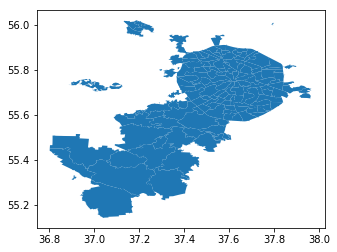

In [80]:
import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('atd/mo.shp')
#mo_gdf[['ABBREV_AO','geometry']]
mo_gdf[['ABBREV_AO','geometry']].plot()

Как видите, это привычный DataFrame. Поле geometry - представление географических объектов (в данном случае - полигонов) в виде WKT, well known text (подробнее - https://en.wikipedia.org/wiki/Well-known_text). Можно довольно просто построить карту наших объектов.

In [81]:
mo_gdf['ABBREV_AO'].replace(to_replace=[u'ЗелАО', u'САО', u'СВАО', u'ВАО', u'ЮВАО', u'ЮАО', u'ЮЗАО', u'ЗАО', u'СЗАО', u'ЦАО', u'Новомосковский', u'Троицкий'], 
    value=['ZelAO', 'SAO', 'SVAO', 'VAO', 'UVAO', 'UAO', 'UZAO', 'ZAO', 'SZAO', 'TSAO', 'NewMsk', 'NewMsk'], inplace=True)

Угадывается Москва! Правда, не совсем привычо выглядит. Причина в проекции карты.

Итак, представим наши данные в более привычной проекции Web Mercator (исходную проекцию можно легко получить по параметру crs). Окрасим полигоны по названию Административного округа. Ширину линий выставим 0,5. Метод окраски cmap использует стандартные значения matplotlib. Чтобы увидеть легенду карты,  задаем параметр legend. Ну а figsize отвечает за размер нашей карты.

In [82]:
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

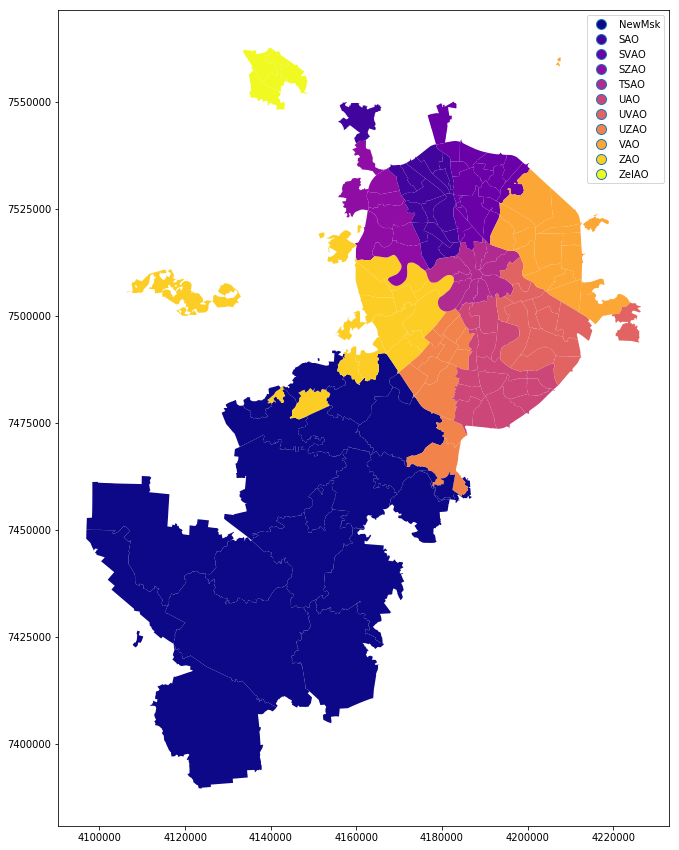

In [84]:
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'}) #непосредственно преобразование проекции
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])
#mo_gdf_wm.sort_values(by=['ABBREV_AO'],ascending=True)[['ABBREV_AO','geometry']]
#g=gpd.GeoSeries(mo_gdf_wm.loc[mo_gdf_wm['ABBREV_AO']=='ZAO']['geometry'])
#boundary = gpd.GeoSeries(cascaded_union(g))


Добавим в результирующий фрейм data_info строку geometry - геоданные по округам для прорисовки проекции с необходимыми показателями на карте.

In [85]:
for x in header_index:
    data_info.loc['okrug_opis',x] = x

In [86]:
for x in header_index:
    g=gpd.GeoSeries(mo_gdf_wm.loc[mo_gdf_wm['ABBREV_AO']==x]['geometry'])
    data_info.loc['geometry',x] = gpd.GeoSeries(cascaded_union(g)).geometry[:][0]
    data_info.loc['okrug',x] = x
    #print(gpd.GeoSeries(cascaded_union(g)).cx) 
    del g
data_info

,TSAO,SAO,SVAO,VAO,UVAO,UAO,UZAO,ZAO,SZAO,ZelAO,NewMsk
id,,,,,,,,,,,
nasel,764500,1.1548e+06,1.4083e+06,1.5008e+06,1.3723e+06,1.7676e+06,1.4204e+06,1.3534e+06,984000,235200,302600
zarplata,93504.6,74543.1,61219.5,55174.6,63240.2,61695.9,75779.7,80683.4,60754.1,52922.1,54958.3
azs,31,69,84,73,95,101,93,94,63,13,43
azs_prc,4.08,9.09,11.07,9.62,12.52,13.31,12.25,12.38,8.3,1.71,5.67
nasel_prc,6.23,9.42,11.48,12.24,11.19,14.41,11.58,11.04,8.02,1.92,2.47
zp_index,1.19,0.95,0.78,0.7,0.8,0.78,0.96,1.03,0.77,0.67,0.7
trafik,1.65,0.81,0.72,0.70,0.67,0.82,0.99,0.97,0.61,0.13,0.25
class_h,7,22,30,24,39,38,37,38,24,9,16
class_m,9,13,21,17,20,12,14,13,7,1,2


In [87]:
data_info.T['okrug_opis'].replace(to_replace=['ZelAO', 'SAO', 'SVAO', 'VAO', 'UVAO', 'UAO', 'UZAO', 'ZAO', 'SZAO', 'TSAO', 'NewMsk'], 
    value=[u'Зеленограде', u'Северном АО', u'Северо-Восточном АО', u'Восточном АО', u'Юго-Восточном АО', u'Южном АО', u'Юго-Западном АО', u'Западном АО', u'Северо-Западном АО', u'Центральном АО', u'Новомосковском АО'], inplace=True)

In [88]:
geo = gpd.GeoDataFrame(data_info.T)

Можно построить карту и по типу муниципального образования:

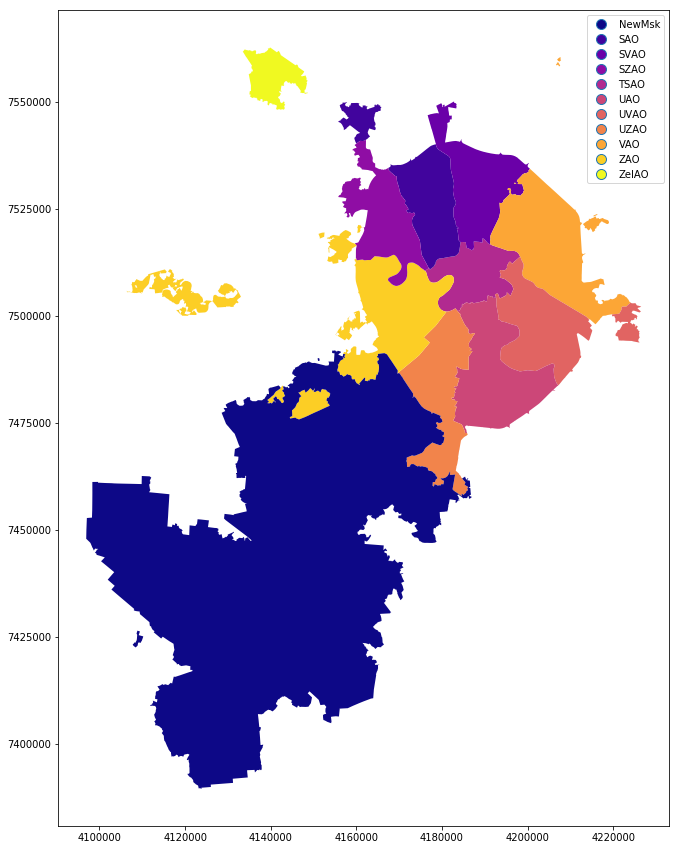

In [89]:
geo.plot(column = 'okrug', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])

### Построим ряд простых категориальных карт, где отображаются АЗС, занимающие лидерство в округе, вторые позиции. А также карты с отображением плотности населения, количества АЗС и зар.плат.

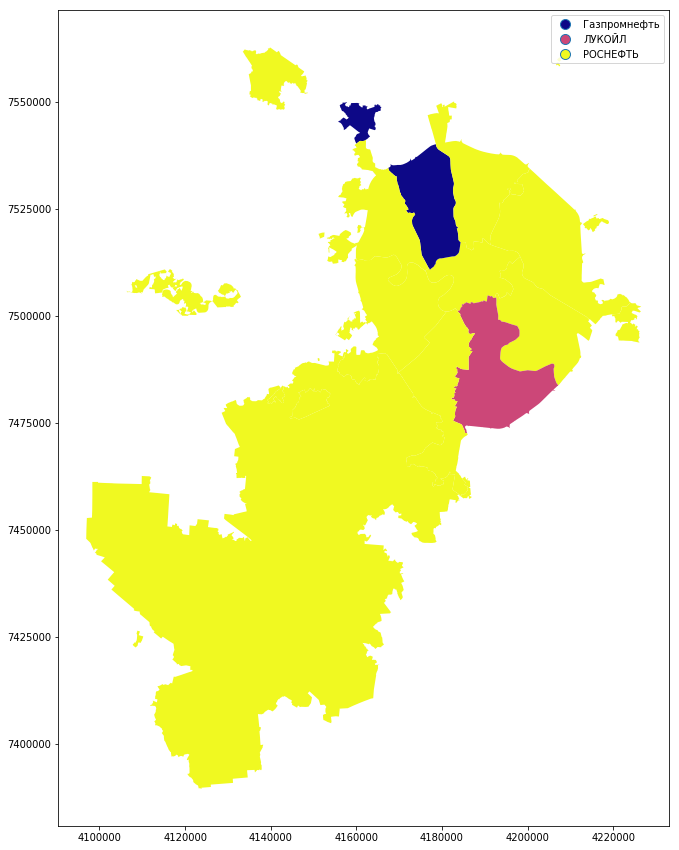

In [91]:
geo.plot(column = 'topnew1', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])

--------- Карта лидеров количества АЗС по округам ---------------

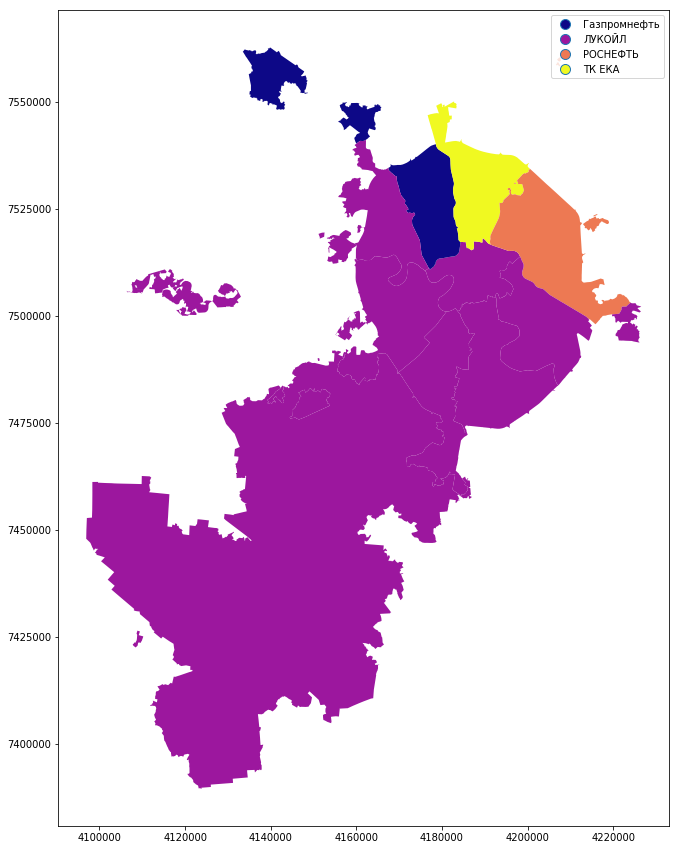

In [98]:
geo.plot(column = 'top1', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])

--------- Карта лидеров количества АЗС по округам (до объединения Роснефти) ---------------

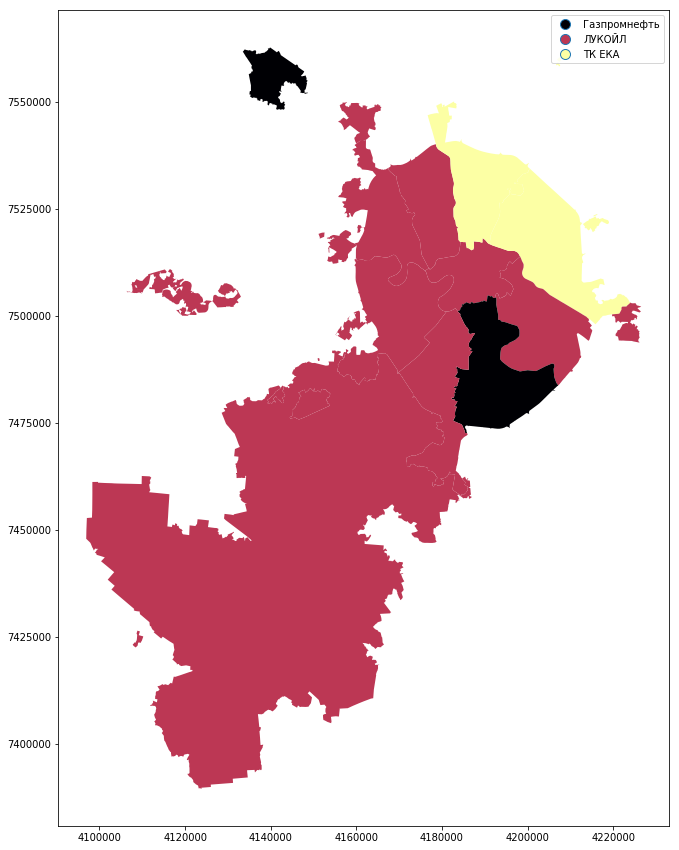

In [92]:
geo.plot(column = 'topnew2', linewidth=0, cmap='inferno', legend=True, figsize=[15,15])

--------- Карта вторых по количеству сетей АЗС по округам ---------------

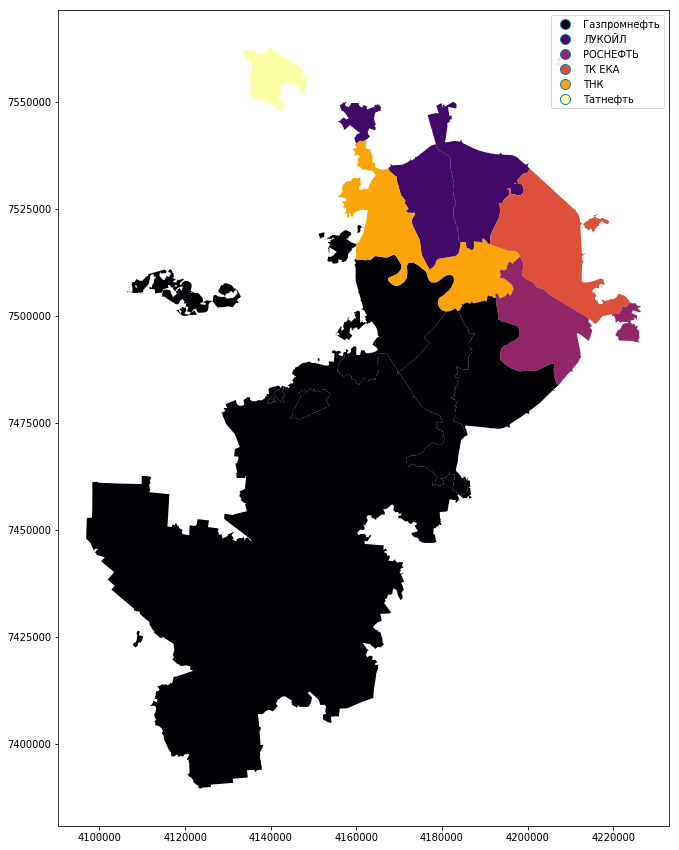

In [99]:
geo.plot(column = 'top2', linewidth=0, cmap='inferno', legend=True, figsize=[15,15])

--------- Карта вторых по количеству сетей АЗС по округам (до объединения Роснефти) ---------------

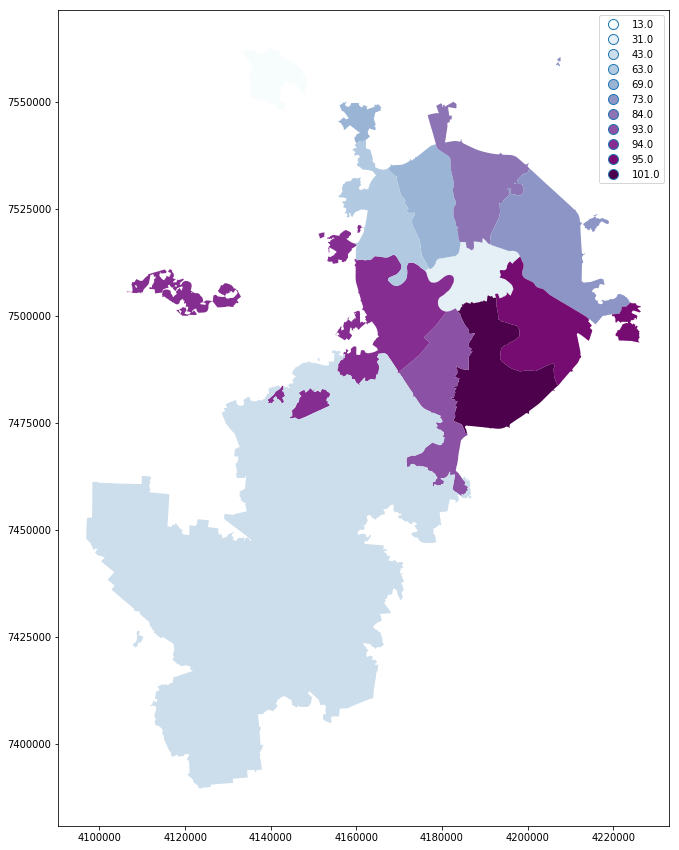

In [93]:
geo.plot(column = 'azs', linewidth=0, cmap='BuPu', legend=True, figsize=[15,15])

--------- Карта плотности АЗС по округам ---------------

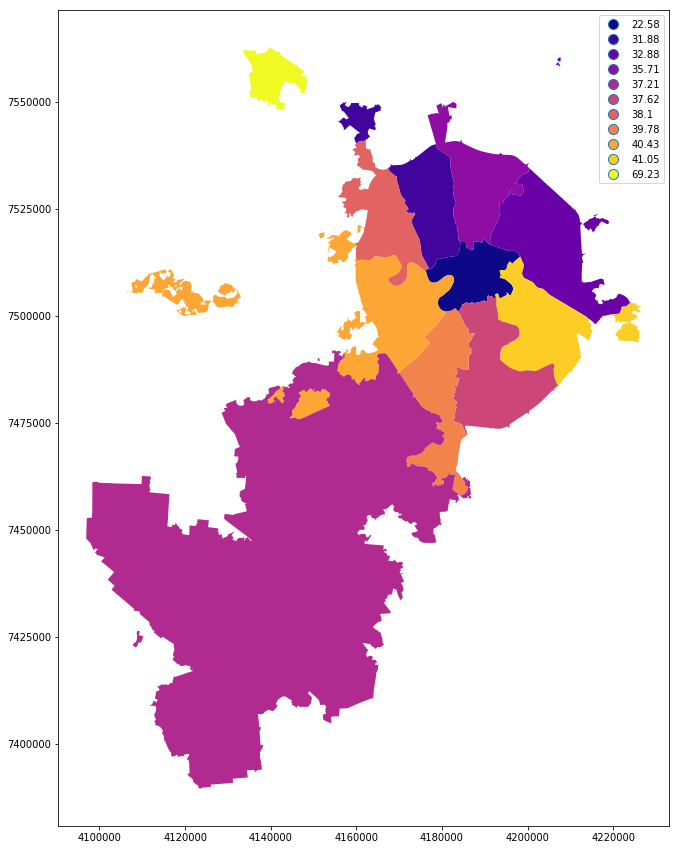

In [94]:
geo.plot(column = 'class_h_prc', linewidth=0, cmap='plasma', legend=True, figsize=[15,15])

--------- Карта процентного содержания АЗС с высоким качеством обслуживания по округам ---------------

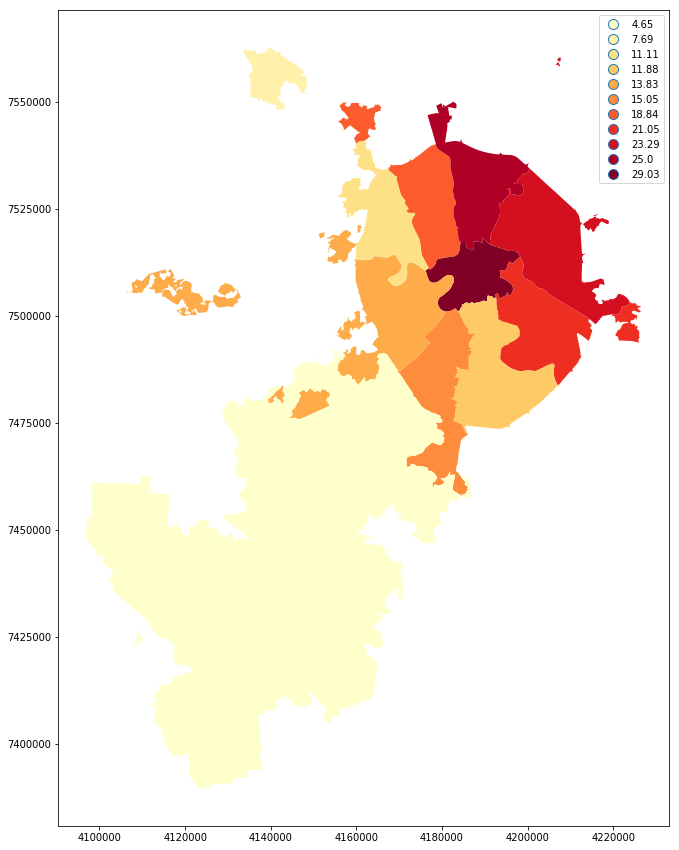

In [95]:
geo.plot(column = 'class_m_prc', linewidth=0, cmap='YlOrRd', legend=True, figsize=[15,15])

--------- Карта процентного содержания АЗС со средним качеством обслуживания по округам ---------------

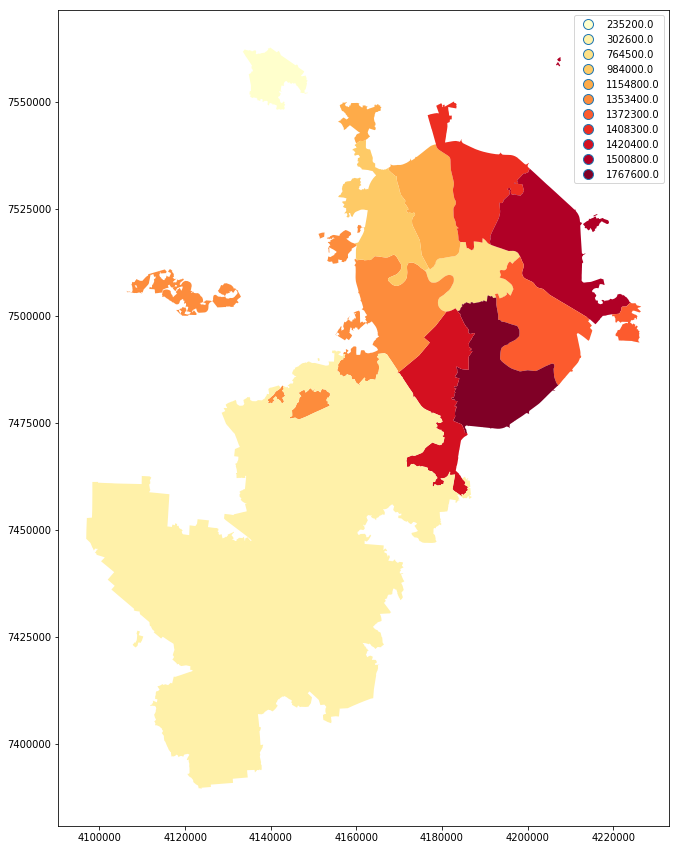

In [96]:
geo.plot(column = 'nasel', linewidth=0, cmap='YlOrRd', legend=True, figsize=[15,15])

--------- Карта плотности населения по округам ---------------

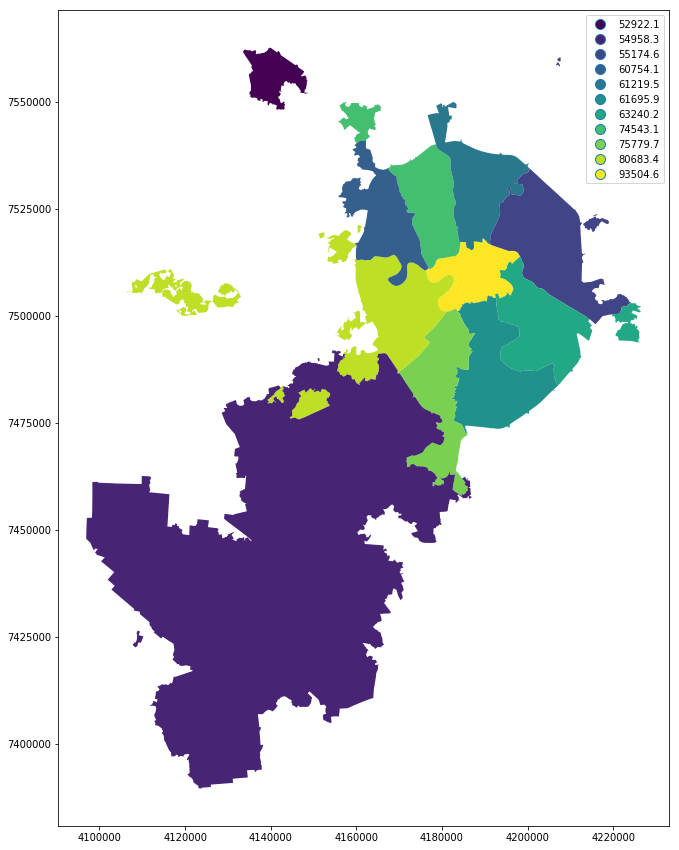

In [97]:
geo.plot(column = 'zarplata', linewidth=0, cmap='viridis', legend=True, figsize=[15,15])

--------- Карта плотности средних зар. плат по округам ---------------

Отлично! У нас получилась симпатичная визуализация. Но хочется и базовую карту, и навигацию, и инфоокна! На помощь нам придет библиотека cartoframes

# Визуализация геоданных с помощью folium

Итак, нам хотелось бы получить не только навигацию, но и инфоокна на карте. А еще получить возможность публикации визуализации на своем сервере или на github. Нам поможет folium.

In [105]:
import folium
import json
import warnings
warnings.filterwarnings("ignore")

In [106]:
geo.crs = ({'init' :'epsg:3857'})
geo = geo.to_crs({'init' :'epsg:4326'})

Простая визуализация наподобие Carto делается достаточно просто.

Что происходит?  
* мы создаем инстанс карты, m, с центром в выбранных координатах;
* добавляем инстанс картограммы (choropleth)

В инстансе картограммы мы задаем много атрибутов:  
* geo_data - геоданные, мы конвертируем данные нашего датафрейма в geojson;
* name - задаем имя слоя;
* data - непосредственно данные, их мы выбираем тоже из датафрейма;
* key_on - ключ для соединения (обратите внимание, в geojson все атрибуты сложены в отдельный элемент, properties);
* columns - ключ и атрибут для раскрашивания;
* fill_color, fill_opacity, line_weight, line_opacity  - цветовая шкала заливки, прозрачность заливки, ширина и прозрачность линий;
* legend_name - заголовок легенды;
* highlight  - добавление интерактива (подсветки при наведении и приближения при клике) у объектов.

Цветовая шкала основывается на библиотеке Color Brewer: http://colorbrewer2.org.

In [107]:
m = folium.Map(location=[55.764414, 37.647859])
m.choropleth(
    geo_data=geo[['okrug', 'geometry']].to_json(),
    name='choropleth',
    data=geo[['okrug', 'azs']],
    key_on='feature.properties.okrug',
    columns=['okrug', 'azs'],
    fill_color='YlGnBu',
    line_weight=1,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='type',
    highlight = True
)
m

Итак, у нас получилась интерактивная картограмма. Но хотелось бы и инфоокон.

Итак, у нас есть 3 сети, лидирующих по количеству АЗС в каждом округе. Для каждой из них мы определим базовый цвет по плотности населения.

In [108]:
print(set(geo['nasel'].values))

{1500800.0, 984000.0, 235200.0, 302600.0, 1372300.0, 1408300.0, 1154800.0, 1767600.0, 1420400.0, 764500.0, 1353400.0}


Напишем функцию определения цвета согласно плотности населения:

In [109]:
def nasel_color(feature):
    nas = feature['properties']['nasel']
    if nas < 800000.0:
        color = '#006400'
    elif 801000.0 < nas < 1000000.0:
        color = '#2E8B57'
    elif 1001000.0 < nas < 1200000.0:
        color = '#00FA9A'
    elif 1201000.0 < nas < 1410000.0:
        color = '#98FB98'
    elif 1411000.0 < nas < 1501000.0:
        color = '#7FFF00'
    else:
        color = '#ADFF2F'
    return {"fillColor":color, "fillOpacity":0.8,"opacity":0}

Теперь напишем функцию формирования html для инфоокна.

In [118]:
def popup_html(feature):
    html = '<h5> Распределение АЗС в {}</h5>'.format(feature['properties']['okrug_opis'])
    html += '<br><b>Cо среднечисленным населением</b>: {} чел.'.format(feature['properties']['nasel'])
    html += '<br><b>C среднемесячной зар. платой</b>: {} руб.'.format(feature['properties']['zarplata'])
    html += '<br><b>C коэффициентом траффика</b>: {}.<br>'.format(feature['properties']['trafik'])
    html += '<br><b>C содержанием АЗС высокого уровня</b> - {}%.'.format(feature['properties']['class_h_prc'])
    html += '<br><b>C содержанием АЗС среднего уровня</b> - {}%.<br>'.format(feature['properties']['class_m_prc'])
    html += '<br><b>Тройка лидеров сетей АЗС в округе</b>:<br><br>до увеличения сети Роснефть:'
    i=1
    for p in ['top1', 'top2', 'top3']:
        if feature['properties'][p+'_val'] > 0:
            html += '<br><b>{}. {}</b>: {} азс'.format(i,feature['properties'][p], feature['properties'][p + '_val'])
            i+=1
    i=1
    html += '<br><br>после увеличения сети Роснефть:'
    for p in ['topnew1', 'topnew2', 'topnew3']:
        if feature['properties'][p+'_val'] > 0:
            html += '<br><b>{}. {}</b>: {} азс'.format(i,feature['properties'][p], feature['properties'][p + '_val'])
            i+=1
    return html

Что происходит? Мы конвертируем каждый объект датафрейма в geojson и добавляем его к карте, привязывая к каждому стиль, поведение при наведении и инфоокно.

In [119]:
m = folium.Map(location=[55.764414, 37.647859], zoom_start=9)

for mo in json.loads(geo.to_json())['features']:
    gj = folium.GeoJson(data=mo, style_function = nasel_color, control=False, highlight_function=lambda x:{"fillOpacity":1, "opacity":1}, smooth_factor=0)
    folium.Popup(popup_html(mo)).add_to(gj)
    gj.add_to(m)
m

In [120]:
folium.Map?

Наконец, мы сохраняем нашу карту. Ее можно опубликовать, например, на Github

In [121]:
m.save('tmp/map.html')

# Заключение

С помощью простых инструментов визуализации геоданных можно найти бесконечный простор для инсайтов. А немного поработав над данными и визуализацией, можно успешно опубликовать ваши инсайты на Carto или на github.

Исходя из численности АЗС и объемов выручки ключевых игроков в Московском регионе лидером регионального рынка услуг в сфере топливоснабжения является компания АО "РН-Москва" (контролируемая доля рынка - 17,2%) Вторым по значимости игроком в регионе является ООО "ЛУКОЙЛ-Центрнефтепродукт" (12,1%). В целом на ТОП-5 игроков рынка приходится 50,0% рынка моторного топлива.

Среди конкурентов АО "РН-Москва" наибольшую долю рынка в Московском регионе занимает бренд "Лукойл", оценочно контролируя около 12,1% рынка. Вторым по значимости брендом является "Газпромнефть" (9,8% рынка). В целом на ТОП-5 брендов оценочно приходится 41,6% продаж автомобильного топлива в Московском регионе.

Рынок автомобильных топлив в Московском регионе в среднесрочной перспективе продолжит демонстрировать достаточно стабильный рост несмотря на снижение темпов роста региональной экономики в 2014-2016 гг. С учетом прогнозируемого роста численности населения указанной территории, уровня автомобилизации населения и роста его транспортной подвижности прогнозный среднегодовой рост потребления автомобильных бензинов в Московском регионе на 2015-2020 гг. оценивается в 2,2%. При этом прогнозное потребление бензина к 2020 г может составить 8,3 млн. т.

Еще одной важной точкой роста бизнеса игроков рынка будет являться диверсификация структуры доходов с увеличением доли сопутствующих услуг в совокупном объеме продаж.

В целом можно охарактеризовать рынок Москвы и Московской области, как активно развивающийся, с большим потенциалом развития для всех сетей, т.к., во-первых, достаточно весома доля прочих несетевых АЗС, а, во-вторых, ведется активная градостроительная политика Москвы и Подмосковья. 

Большинство сетей АЗС находится в одном диапазоне значений по многим параметрам, несмотря на то, что разные сети АЗС нацелены на свою целевую аудиторию. С развитием в равной степени во всех сетях современных технологий в области оказания услуг и реализации продуктов, определяющим фактором становится локальный характер развития, т.е. охват территории, степень доступности, удобство в расположении. 

В качестве перспектив развития сетей АЗС АО "РН-Москва", можно отметить, что в Москве, с долей присутствия порядка 22%, в ближайшем будущем следует увеличить присутствие брендов Роснефть и ВР в ЮАО, с нынешних 1% и 4% соответственно, также в ЮЗАО увеличить присутствие бренда Роснефть с текущих 3%. 
В Московской области, с долей присутствия сети АЗС АО "РН-Москва" в размере 14-15%, для брендов Роснефть и ВР перспективными являются Пушкинский и Люберецкий районы, отдельно для бренда Роснефть следует рассмотреть Балашихинский, Одинцовский и Орехово-Зуевский районы. Также стратегически следует рассмотреть вопрос по вхождению в Химкинский и Щелковский районы, где пока нет присутствия ни одного бренда. Данные рекомендации сделаны на основе плотности населения и долей присутствия сетей АЗС АО "РН-Москва" в каждом районе и округе Московского региона. 
Говоря о качественной характеристике брендов АЗС АО "РН-Москва", можно сказать, что в целом они нацелены на различные категории потребителей. ВР и ТНК достались компании Роснефть от купленной ранее нефтяной компании ТНК-ВР, в рамках которой эти сети разделялись на премиальный и бюджетный сегменты. После объединения их с сетью Роснефть в рамках одной материнской компании, можно отметить, что бренд Роснефть находится в среднем сегменте между ВР и ТНК, и адекватно вписывается в общую линейку брендов. Можно только подчеркнуть стратегическую важность такого разделения по целевым категориям потребителей и необходимость дальнейшего развития всех трех сетей в тех же сегментах.
